In [1]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.layers import Dropout
import keras.backend as K
from datetime import timedelta
import seaborn as sns 
import numpy as np

In [2]:
file_path = 'hourlyCompleteData.csv'  
stocksData = pd.read_csv(file_path)

In [3]:
stocksData.tail()

,returns,datetime,v,vw,o,c,h,l,t,n,ema_fast,ema_slow,rsi,dn,mavg,up,atr,macd,signal
7058,-0.000002,2023-12-08 20:00:00,130118.166667,195.697770,195.696857,195.696435,195.746342,195.648072,1.702067e+12,1323.650000,194.431379,193.362309,71.966368,193.433405,194.479710,195.526016,0.257405,0.552885,0.509374
7059,-0.000012,2023-12-08 21:00:00,59744.608696,195.684626,195.701783,195.699354,195.708943,195.655220,1.702071e+12,36.434783,194.546649,193.445774,71.984937,193.366716,194.532844,195.698971,0.247706,0.569087,0.521317
7060,-0.000010,2023-12-08 22:00:00,32368.096774,195.479658,195.679761,195.677816,195.681687,195.675665,1.702074e+12,17.032258,194.649483,193.525490,71.617461,193.313897,194.574172,195.834447,0.237039,0.580798,0.533213
7061,-0.000008,2023-12-08 23:00:00,691.423077,195.701550,195.702331,195.700742,195.703377,195.699973,1.702078e+12,10.615385,194.745052,193.603178,71.778480,193.285454,194.632588,195.979721,0.226968,0.589801,0.544531
7062,0.000000,2023-12-09 00:00:00,442.809524,195.720752,195.720952,195.720952,195.721429,195.720476,1.702082e+12,10.333333,194.833770,193.678813,71.925901,193.285170,194.700011,196.114853,0.217145,0.596326,0.554890



| Column    | Description |
|-----------|-------------|
| `v`       | Volume: The trading volume of the symbol in the given time. |
| `vw`      | Volume Weighted Average Price: An indicator of trading volume and price that provides the average price at which a stock has traded during the day. |
| `c`       | Close Price: The close price of the stock in the given time frame. |
| `h`       | Highest Price: The highest price of the stock in the given time frame. |
| `l`       | Lowest Price: The lowest price of the stock in the given time frame. |
| `n`       | Number of Transactions: The number of transactions in the time frame. |
| `o`       | Open Price: The open price of the stock at the beginning of the time period. |
| `t`       | Unix Msec Timestamp: The Unix Msec timestamp for the start of the aggregate window. |
| `datetime`| Date and Time: The precise time and date the stocksData point was captured, giving our study a clear sense of its temporal context. |


#### Converting the data type of the datetime column 

In [4]:
stocksData['datetime'] = pd.to_datetime(stocksData['datetime'])

In [5]:
stocksData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7063 entries, 0 to 7062
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   returns   7063 non-null   float64       
 1   datetime  7063 non-null   datetime64[ns]
 2   v         7063 non-null   float64       
 3   vw        7063 non-null   float64       
 4   o         7063 non-null   float64       
 5   c         7063 non-null   float64       
 6   h         7063 non-null   float64       
 7   l         7063 non-null   float64       
 8   t         7063 non-null   float64       
 9   n         7063 non-null   float64       
 10  ema_fast  7043 non-null   float64       
 11  ema_slow  7009 non-null   float64       
 12  rsi       7042 non-null   float64       
 13  dn        7043 non-null   float64       
 14  mavg      7043 non-null   float64       
 15  up        7043 non-null   float64       
 16  atr       7042 non-null   float64       
 17  macd      7009

#### Missing values

In [6]:
print(stocksData.isnull().sum())

returns      0
datetime     0
v            0
vw           0
o            0
c            0
h            0
l            0
t            0
n            0
ema_fast    20
ema_slow    54
rsi         21
dn          20
mavg        20
up          20
atr         21
macd        54
signal      62
dtype: int64


#### Removing the null values if any

In [7]:
stocksData.dropna(inplace=True)

In [8]:
stocksData.describe()

,returns,datetime,v,vw,o,c,h,l,t,n,ema_fast,ema_slow,rsi,dn,mavg,up,atr,macd,signal
count,7001.000000,7001,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7.001000e+03,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000,7001.000000
mean,-0.000002,2023-01-26 11:49:37.288958976,68131.006179,162.054114,162.054906,162.054542,162.101493,162.007637,1.674736e+12,665.770740,161.995051,161.912441,51.605542,159.798767,161.993351,164.187935,0.420738,0.042466,0.040894
min,-0.000787,2022-03-14 22:00:00,312.000000,124.503510,124.499227,124.502845,124.572147,124.440860,1.647297e+12,6.500000,125.680462,126.543254,13.310903,121.941397,125.813274,127.482968,0.175214,-3.119596,-3.041581
25%,-0.000036,2022-08-19 12:00:00,1409.651163,147.587065,147.590998,147.595649,147.647225,147.555382,1.660912e+12,25.630435,147.388325,147.346088,42.176542,144.678618,147.499671,150.141247,0.324496,-0.486698,-0.486436
50%,0.000000,2023-01-26 22:00:00,27715.625000,162.006183,162.010748,162.007105,162.065242,161.963983,1.674772e+12,88.303571,161.685688,161.516736,52.047623,158.993747,161.635534,164.615956,0.394993,0.127251,0.126578
75%,0.000035,2023-07-06 14:00:00,117268.383333,176.145732,176.145714,176.139261,176.164615,176.113833,1.688654e+12,1187.816667,175.995534,175.952783,61.852115,174.054345,175.903713,178.313004,0.492919,0.638277,0.629472
max,0.000707,2023-12-09 00:00:00,691269.116667,196.448198,196.440688,196.450653,196.516721,196.394312,1.702082e+12,5875.316667,196.027021,195.594388,86.313026,195.771111,196.128325,197.376827,1.064384,2.322346,2.197452
std,0.000086,NaN,83612.523066,17.771847,17.773678,17.773810,17.767092,17.780038,1.589723e+10,845.798461,17.662944,17.480820,13.213623,18.095611,17.686898,17.372256,0.131599,0.864965,0.846851


#### Line chart of prices over time

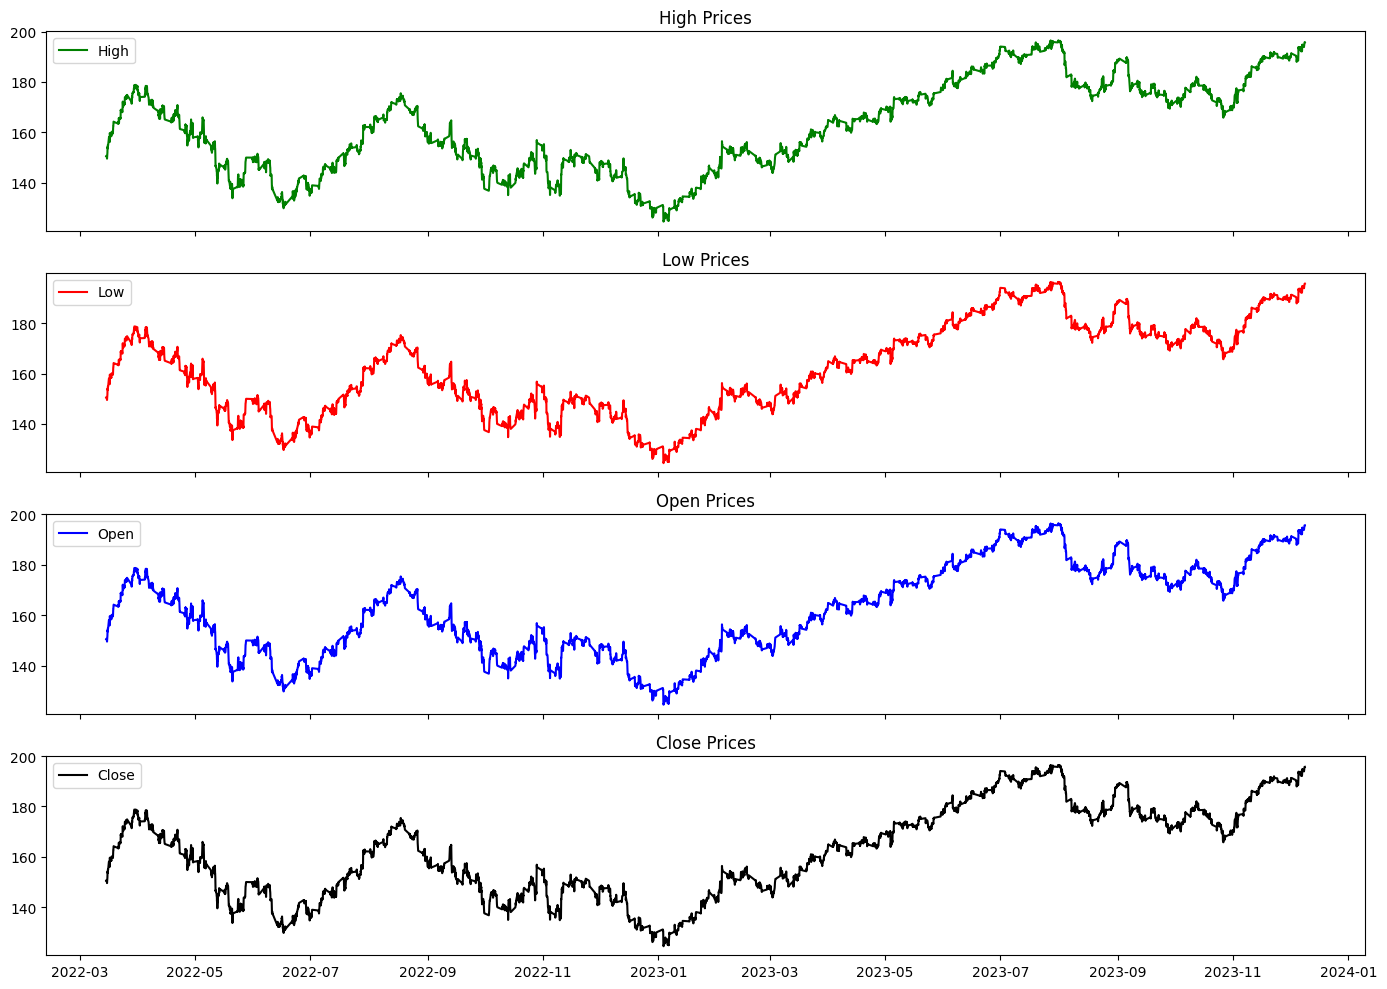

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Plot the 'High' prices
axs[0].plot(stocksData['datetime'], stocksData['h'], label='High', color='green')
axs[0].set_title('High Prices')
axs[0].legend(loc='upper left')

# Plot the 'Low' prices
axs[1].plot(stocksData['datetime'], stocksData['l'], label='Low', color='red')
axs[1].set_title('Low Prices')
axs[1].legend(loc='upper left')

# Plot the 'Open' prices
axs[2].plot(stocksData['datetime'], stocksData['o'], label='Open', color='blue')
axs[2].set_title('Open Prices')
axs[2].legend(loc='upper left')

# Plot the 'Close' prices
axs[3].plot(stocksData['datetime'], stocksData['c'], label='Close', color='black')
axs[3].set_title('Close Prices')
axs[3].legend(loc='upper left')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.tight_layout()
plt.show()


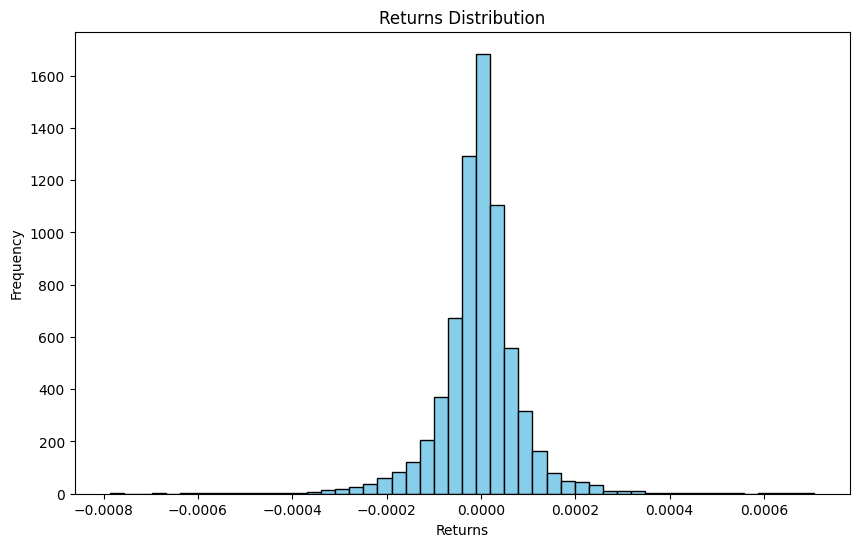

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(stocksData['returns'], bins=50, color='skyblue', edgecolor='black')
plt.title('Returns Distribution')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()


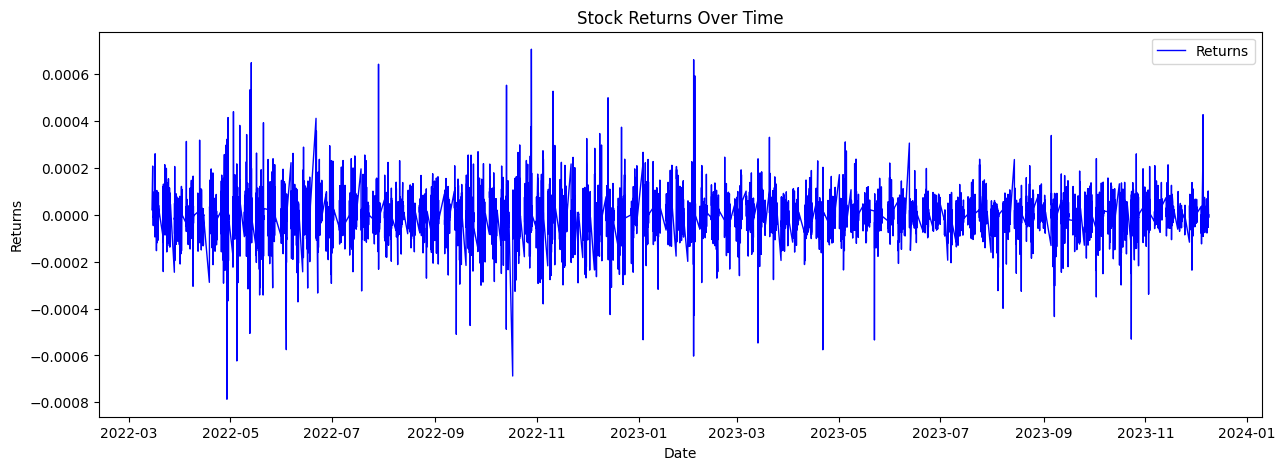

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(stocksData['datetime'], stocksData['returns'], label='Returns', color='blue', linewidth=1)
plt.title('Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

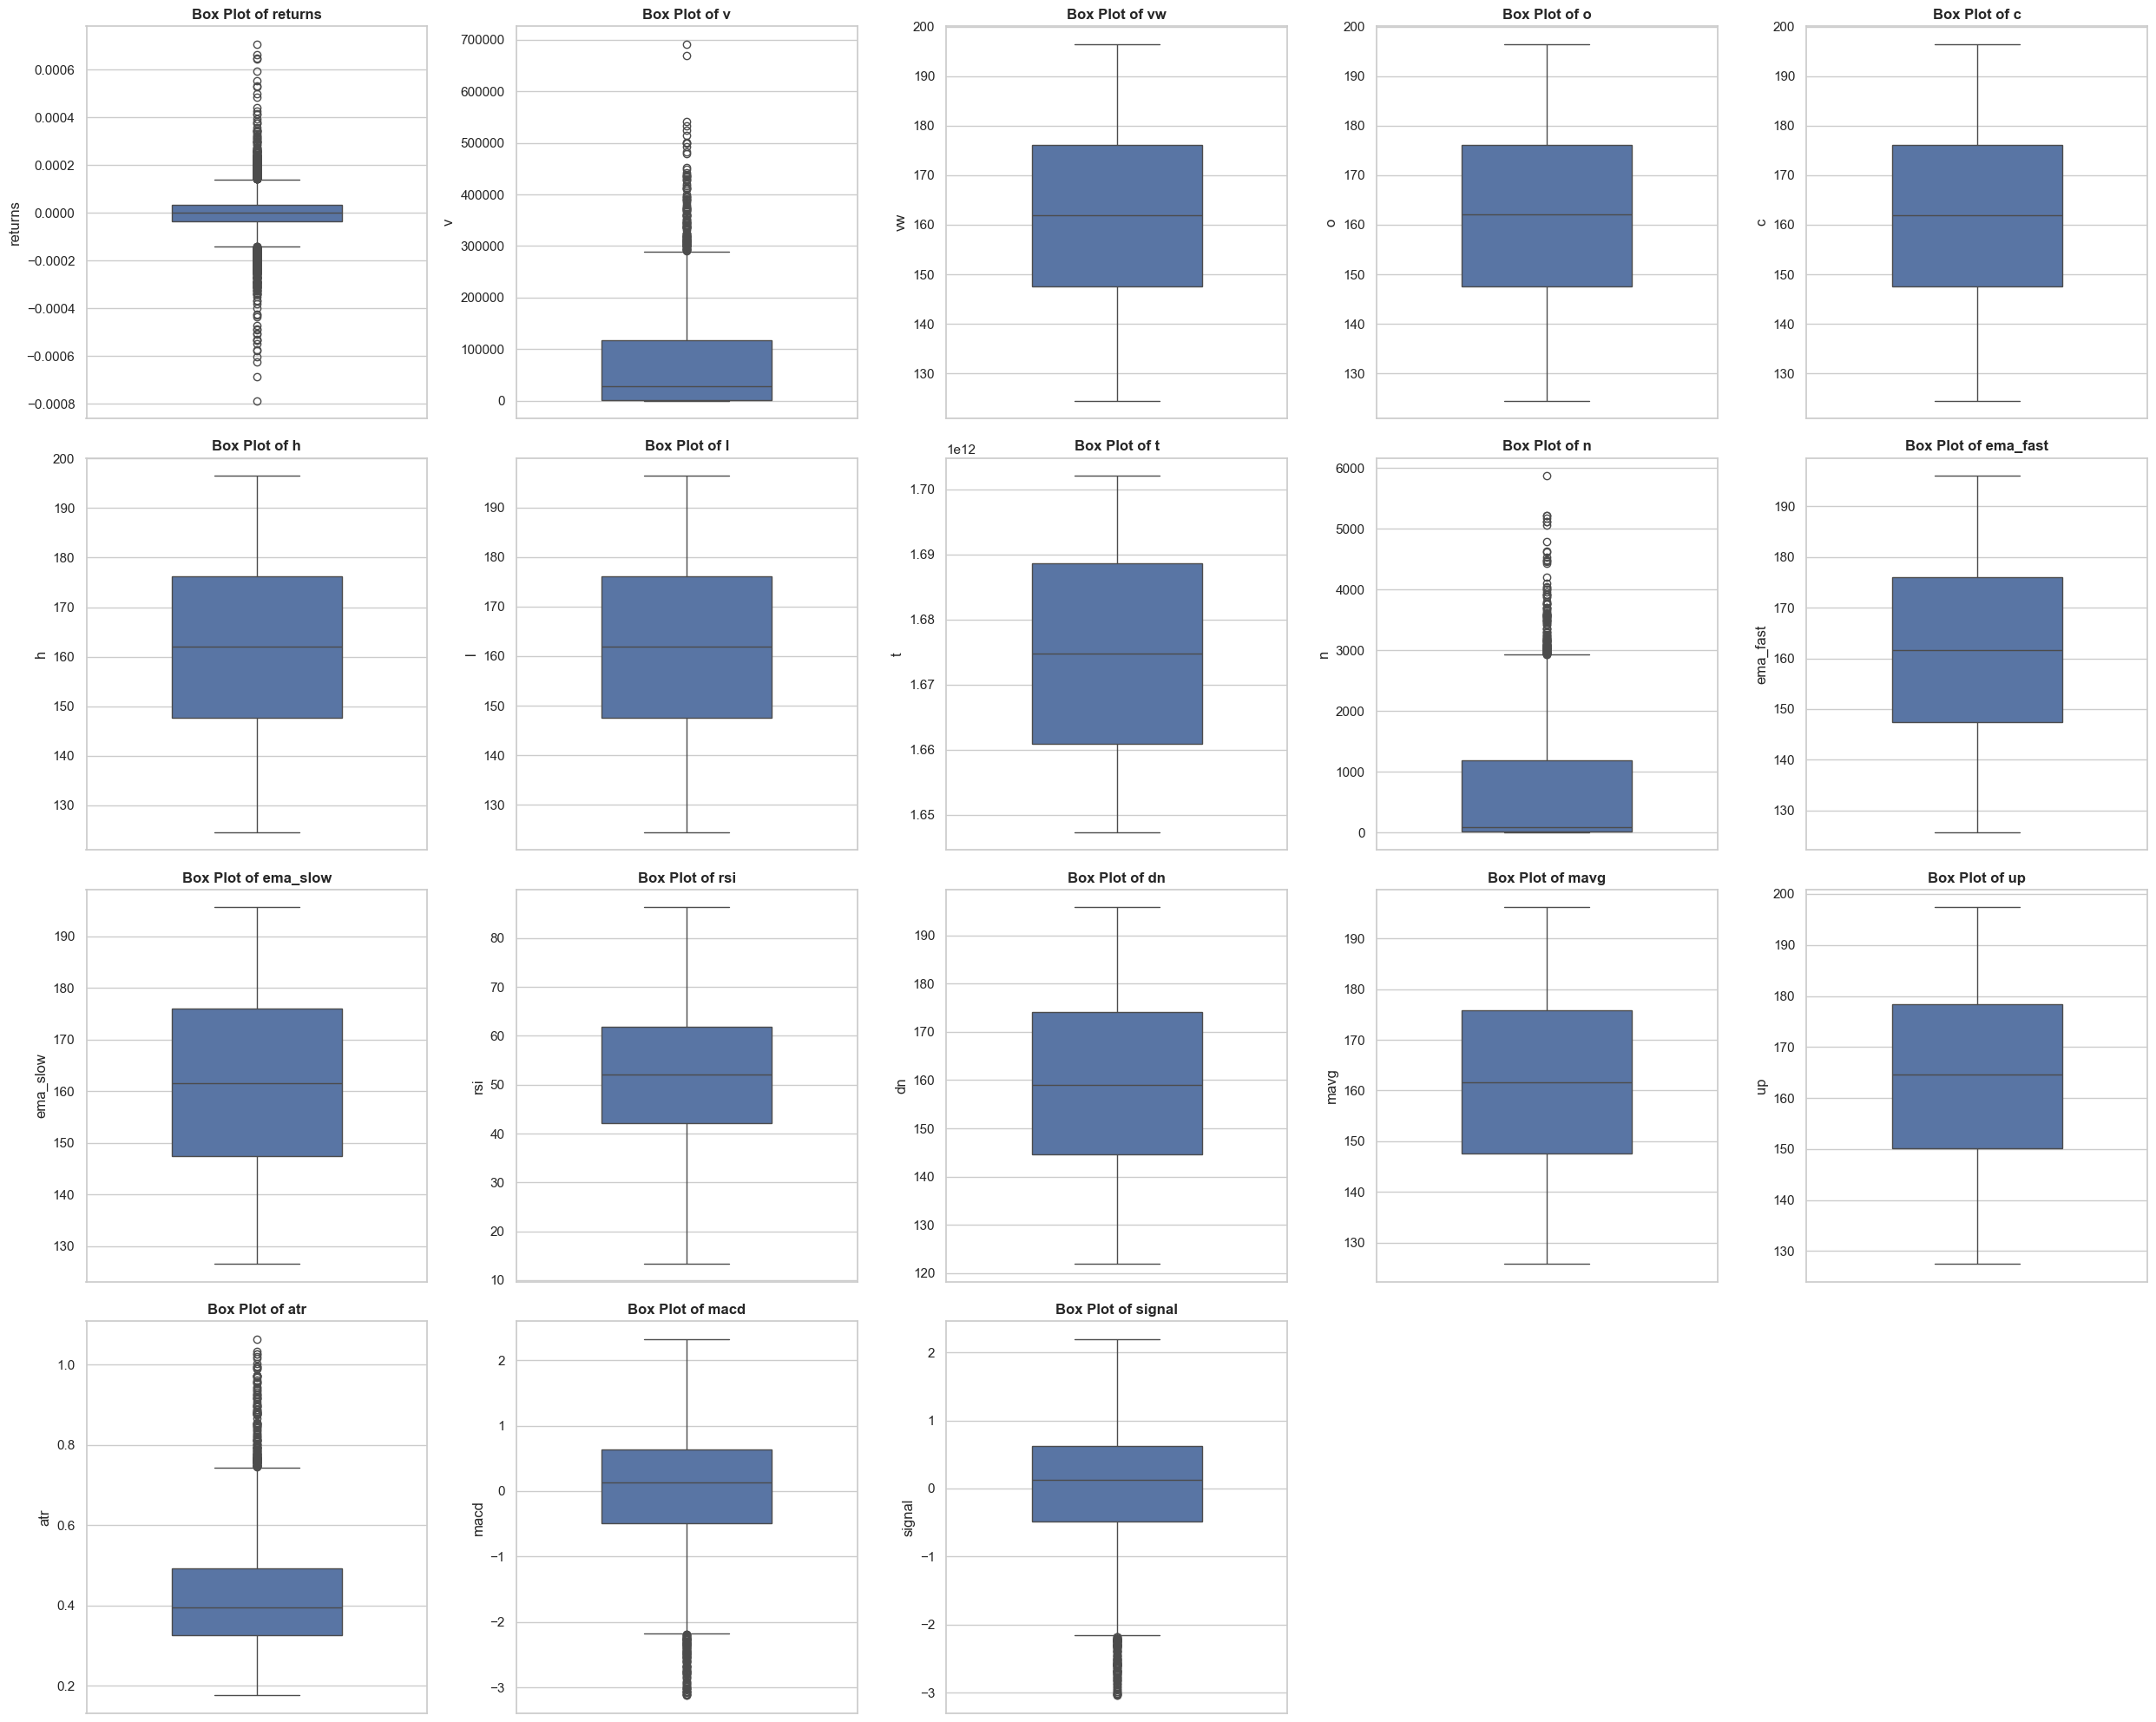

In [12]:
numerical_columns = stocksData.select_dtypes(include=['float64', 'int64']).columns
num_cols = 5  
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 5, num_rows * 5))  
sns.set(style="whitegrid")

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=stocksData[column], width=0.5) 
    plt.title(f'Box Plot of {column}', fontweight='bold')

plt.tight_layout()
plt.show()

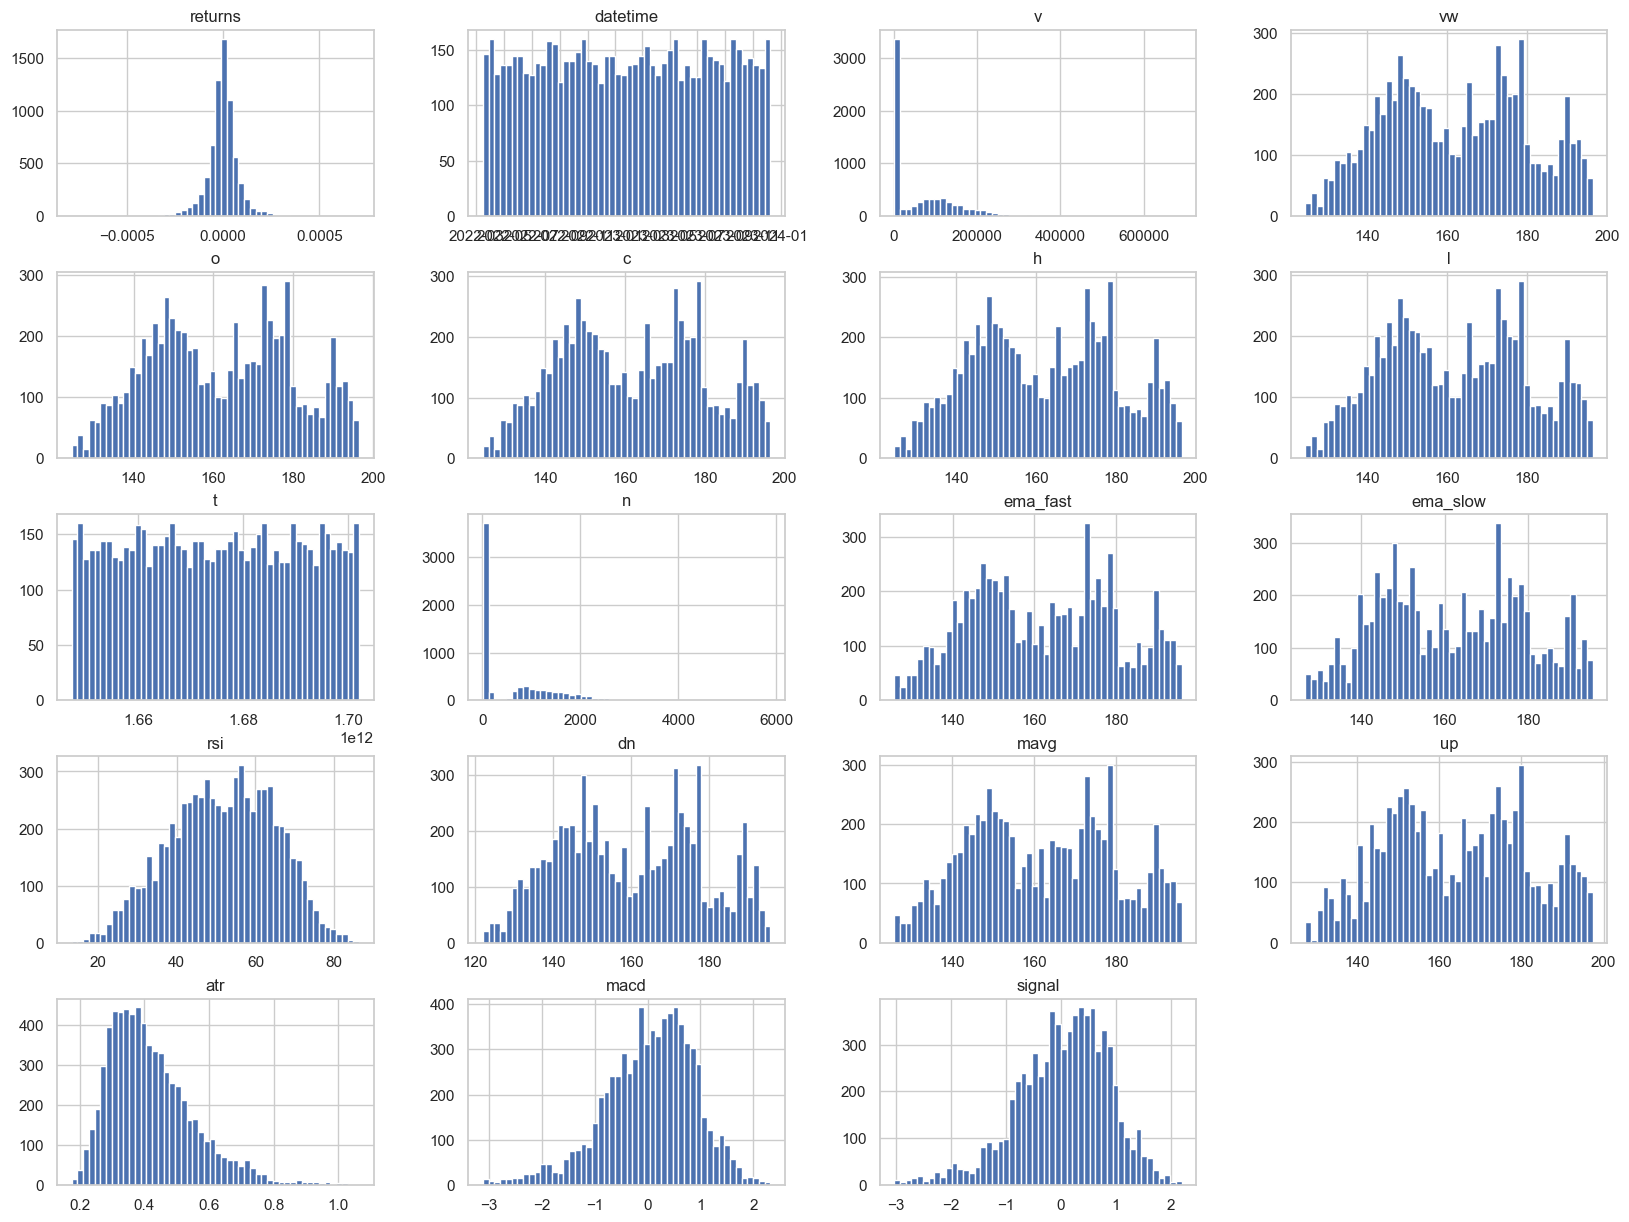

In [13]:
stocksData.hist(bins=50, figsize=(20,15))
plt.show()

Key insights 
- The distribution of the **datetime** column is fairly uniform, which suggests that the data points are distributed evenly over the time period
- The distribution of the **volume** has a right-skewed distribution, indicating that there are periods with very high trading volume, but majority of the time, the volume is lower. This could represent typical trading volume patterns with sporadic spikes due to certain news or announcements.
- The distributions for **open**, **close**, **high** and **low** have similar shapes, which is expected as these prices are often closely related. They have a somewhat bell-shaped distribution but with notable spikes and dips, which could indicate periods of high volatility or stable trading phases.
- This distribution for **number of transactions** shows a right-skewed distribution, with most of the data points having fewer transactions. There are some instances with a very high number of transactions, possibly correlating with the spikes in the volume distribution.

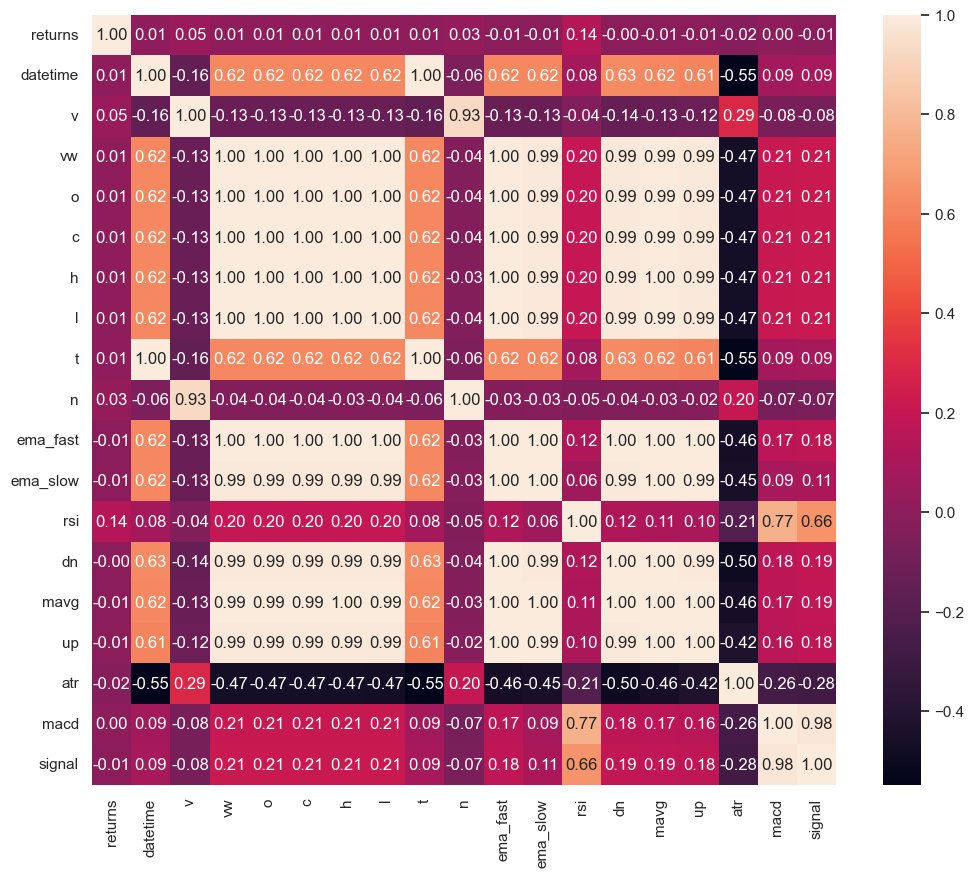

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(stocksData.corr(), annot=True, fmt=".2f", cmap='rocket')
plt.show()

- When it comes to **v** , which tallies the volume of trading, and **n**, the count of transactions, there's a strong connection. It seems the busier the trading day, with more shares changing hands, the higher the number of individual trades occurring.
- Price points during trading — be it the 'vw' or the opening, closing, highest, or lowest prices ('o', 'c', 'h', 'l') — tend to shift in concert, as their correlation coefficients are just under the perfect unity mark.
- The **datetime** variable presents a subtly declining relationship with 'v', the volume of trades, hinting at a very slight trend of trading volume reducing over time. However, this dip is so marginal that it's hard to establish any concrete pattern without additional details.
- Lastly, **n**, or the number of individual transactions, shows a negligible inverse relationship with all price indicators, suggesting there's barely any direct linear link between the sheer number of trades and the movement in price metrics

#### Vanilla LSTM using Multivariate approach

Define a function to create sequences

Selecting all features - here we're using all variables except 'returns' and 'datetime'

In [15]:
features = stocksData.drop(['returns', 'datetime'], axis=1)
target = stocksData['returns']

Scale features

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Scale the target values

In [17]:
target = target.values.reshape(-1, 1)  # reshaping for the scaler
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target).flatten()

Epoch 1/100
158/158 [==============================] - 1s 4ms/step - loss: 1.1685 - val_loss: 0.4282
Epoch 2/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1637 - val_loss: 0.4272
Epoch 3/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1642 - val_loss: 0.4275
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1617 - val_loss: 0.4274
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1609 - val_loss: 0.4276
Epoch 6/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1593 - val_loss: 0.4274
Epoch 7/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1596 - val_loss: 0.4285
Epoch 8/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1675 - val_loss: 0.4270
Epoch 9/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1597 - val_loss: 0.4276
Epoch 10/100
158/158 [==============================] - 0s 3ms/step - loss: 1.1590 - val_lo

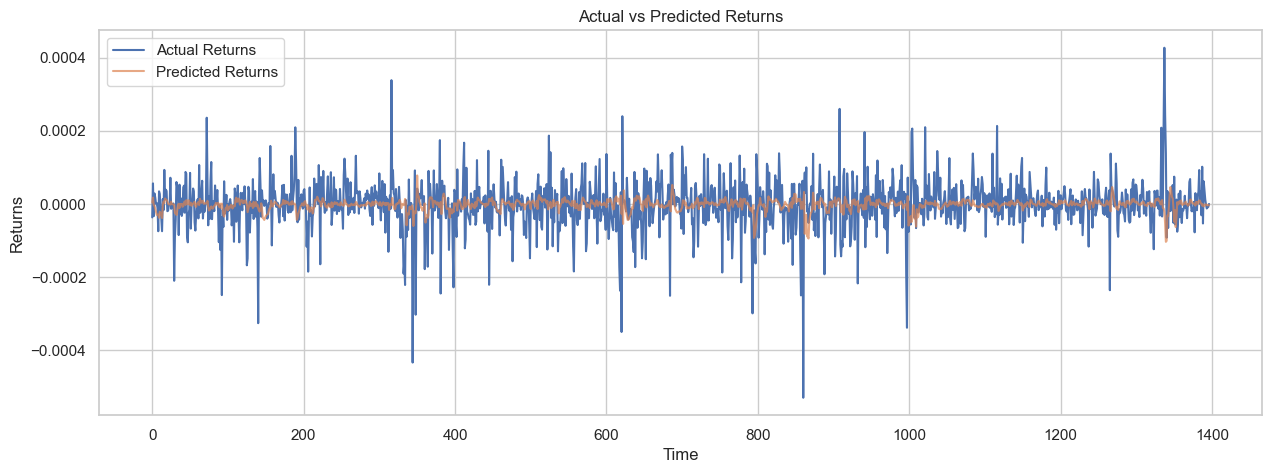

In [18]:

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(stocksData['returns'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (lookback period)
seq_length = 16
X, y = create_sequences(returns_scaled, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predict future returns
predicted_returns = model.predict(X_test)
predicted_returns = scaler.inverse_transform(predicted_returns)  # Inverse scaling to original scale
actual_returns = scaler.inverse_transform(y_test)  # Also invert scaling for actual returns

# Calculate RMSE, MSE, and MAE
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
mse = mean_squared_error(actual_returns, predicted_returns)
mae = mean_absolute_error(actual_returns, predicted_returns)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Optionally, plot the actual vs predicted returns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


Split the data into training and testing sets

In [19]:
stocksData.sort_values('datetime', inplace=True)
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [20]:
seq_length = 16
X, y = create_sequences(scaled_features, scaled_target, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Vanilla LSTM Training

In [21]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_baseline.add(LSTM(100, activation='relu', return_sequences=False))
model_baseline.add(Dense(1))

model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_baseline.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
158/158 [==============================] - 3s 10ms/step - loss: 1.0072 - val_loss: 0.9143
Epoch 2/50
158/158 [==============================] - 1s 9ms/step - loss: 1.0022 - val_loss: 0.9144
Epoch 3/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9979 - val_loss: 0.9203
Epoch 4/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9982 - val_loss: 0.9169
Epoch 5/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9966 - val_loss: 0.9145
Epoch 6/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9964 - val_loss: 0.9171
Epoch 7/50
158/158 [==============================] - 1s 8ms/step - loss: 0.9929 - val_loss: 0.9211
Epoch 8/50
158/158 [==============================] - 1s 8ms/step - loss: 0.9941 - val_loss: 0.9123
Epoch 9/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9933 - val_loss: 0.9172
Epoch 10/50
158/158 [==============================] - 1s 9ms/step - loss: 0.9910 - val_loss: 0.923

In [23]:
predicted_returns = model_baseline.predict(X_test)
predicted_returns = target_scaler.inverse_transform(predicted_returns)

44/44 [==============================] - 0s 3ms/step


In [24]:
actual_returns = target_scaler.inverse_transform(y_test.reshape(-1, 1))

Evaluation

In [25]:
# Calculate MAE
mae = mean_absolute_error(actual_returns, predicted_returns)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns, predicted_returns)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 6.238930939980775e-05
Mean Squared Error (MSE): 9.599529372203951e-09
Root Mean Squared Error (RMSE): 9.797718801947702e-05


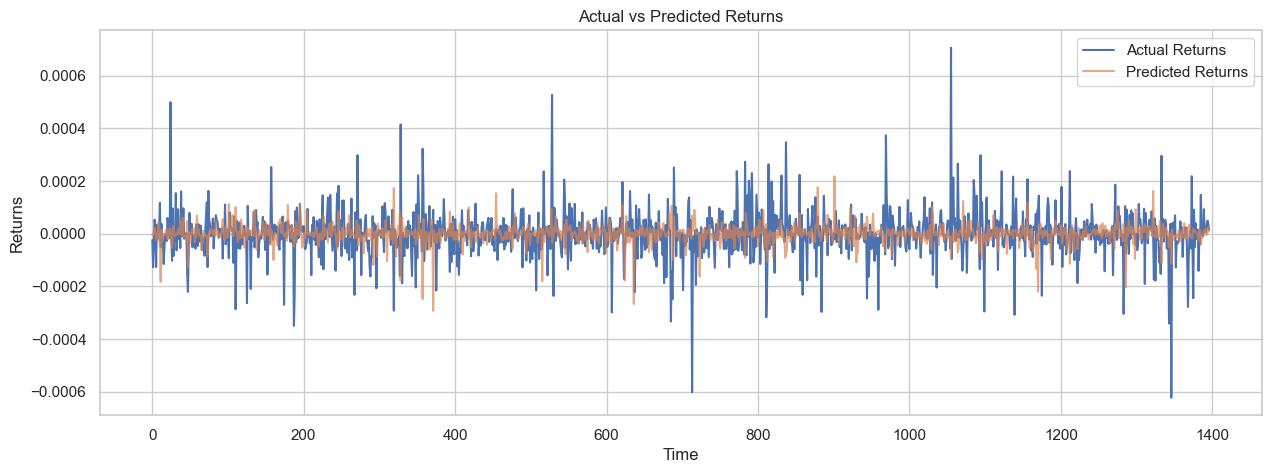

In [26]:
# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


### Parameter Tuning

#### Varying number of sequence lengths

Epoch 1/50
158/158 [==============================] - 3s 6ms/step - loss: 0.3407 - val_loss: 0.3816
Epoch 2/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3391 - val_loss: 0.3808
Epoch 3/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3387 - val_loss: 0.3826
Epoch 4/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3387 - val_loss: 0.3832
Epoch 5/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3382 - val_loss: 0.3821
Epoch 6/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3379 - val_loss: 0.3830
Epoch 7/50
158/158 [==============================] - 1s 3ms/step - loss: 0.3375 - val_loss: 0.3897
Epoch 8/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3371 - val_loss: 0.3814
Epoch 9/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3370 - val_loss: 0.3872
Epoch 10/50
158/158 [==============================] - 1s 4ms/step - loss: 0.3366 - val_loss: 0.3862

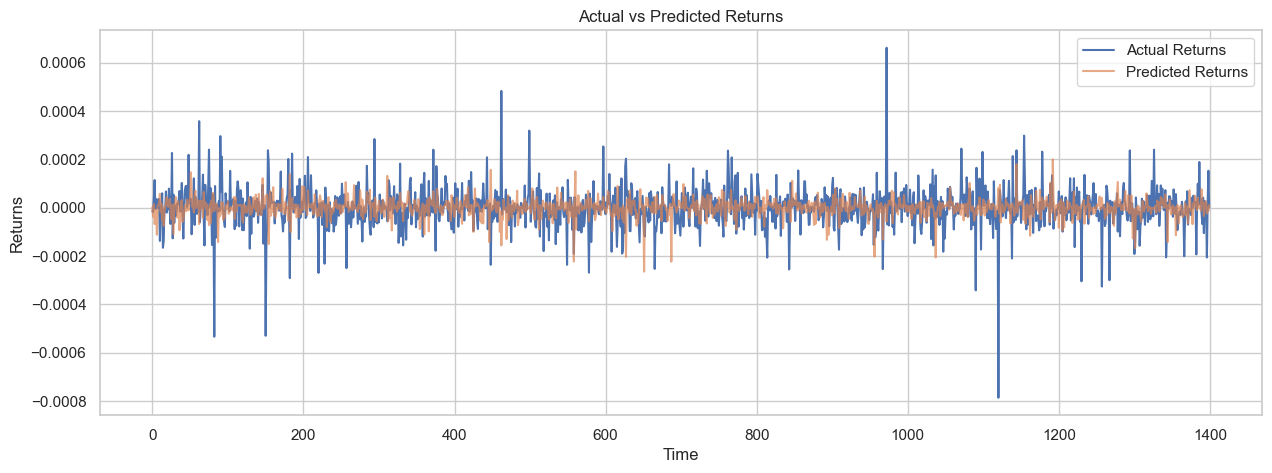

In [27]:
seq_length = 5
X_5, y_5 = create_sequences(scaled_features, scaled_target, seq_length)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)


model_2 = Sequential()
model_2.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_2.add(LSTM(100, activation='relu', return_sequences=False))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='huber_loss')

model_2.fit(X_train_5, y_train_5, epochs=50, batch_size=32, validation_split=0.1)

predicted_returns_2 = model_2.predict(X_test_5)
predicted_returns_2 = target_scaler.inverse_transform(predicted_returns_2)

actual_returns_2 = target_scaler.inverse_transform(y_test_5.reshape(-1, 1))
# Calculate MAE
mae = mean_absolute_error(actual_returns_2, predicted_returns_2)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns_2, predicted_returns_2)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns_2, label='Actual Returns')
plt.plot(predicted_returns_2, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

The performance doesn't really improve

Changing the sequence length to 10

Epoch 1/50
158/158 [==============================] - 4s 7ms/step - loss: 0.3437 - val_loss: 0.3161
Epoch 2/50
158/158 [==============================] - 1s 6ms/step - loss: 0.3420 - val_loss: 0.3143
Epoch 3/50
158/158 [==============================] - 1s 6ms/step - loss: 0.3414 - val_loss: 0.3154
Epoch 4/50
158/158 [==============================] - 1s 5ms/step - loss: 0.3411 - val_loss: 0.3156
Epoch 5/50
158/158 [==============================] - 1s 5ms/step - loss: 0.3407 - val_loss: 0.3149
Epoch 6/50
158/158 [==============================] - 1s 5ms/step - loss: 0.3404 - val_loss: 0.3143
Epoch 7/50
158/158 [==============================] - 1s 5ms/step - loss: 0.3402 - val_loss: 0.3146
Epoch 8/50
158/158 [==============================] - 1s 6ms/step - loss: 0.3398 - val_loss: 0.3148
Epoch 9/50
158/158 [==============================] - 1s 5ms/step - loss: 0.3393 - val_loss: 0.3162
Epoch 10/50
158/158 [==============================] - 1s 6ms/step - loss: 0.3390 - val_loss: 0.3146

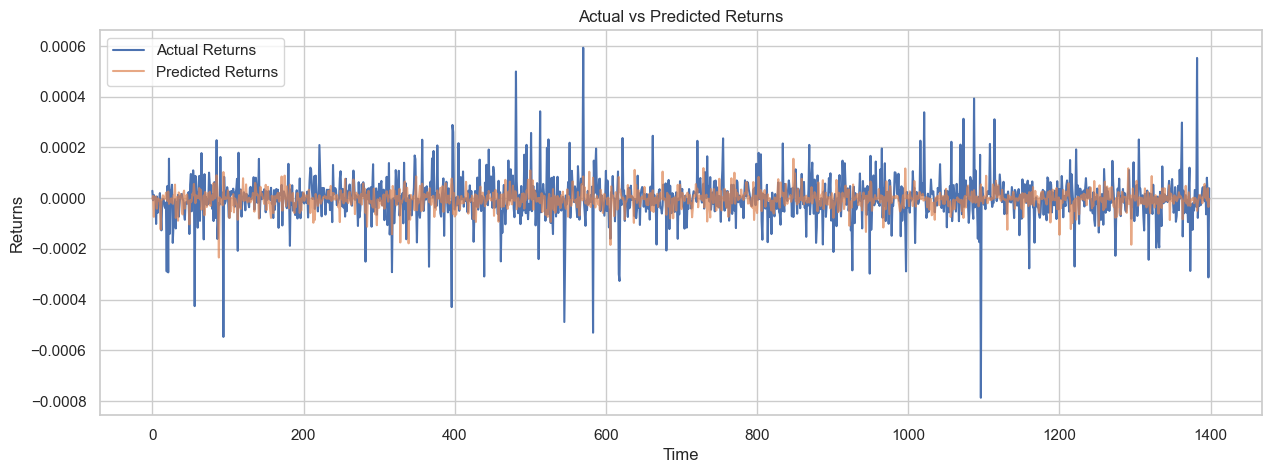

In [28]:
seq_length = 10
X_10, y_10 = create_sequences(scaled_features, scaled_target, seq_length)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)


model_3 = Sequential()
model_3.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_3.add(LSTM(100, activation='relu', return_sequences=False))
model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='huber_loss')

model_3.fit(X_train_10, y_train_10, epochs=50, batch_size=32, validation_split=0.1)

predicted_returns_10 = model_3.predict(X_test_10)
predicted_returns_10 = target_scaler.inverse_transform(predicted_returns_10)

actual_returns_10 = target_scaler.inverse_transform(y_test_10.reshape(-1, 1))
# Calculate MAE
mae = mean_absolute_error(actual_returns_10, predicted_returns_10)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns_10, predicted_returns_10)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns_10, label='Actual Returns')
plt.plot(predicted_returns_10, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

Little to no change in the performance

### Changing sequence length to 32 with an additional layer of 200 neurons

Epoch 1/50
40/40 [==============================] - 10s 132ms/step - loss: 0.3298 - val_loss: 0.3721
Epoch 2/50
40/40 [==============================] - 5s 130ms/step - loss: 0.3292 - val_loss: 0.3733
Epoch 3/50
40/40 [==============================] - 5s 136ms/step - loss: 0.3291 - val_loss: 0.3725
Epoch 4/50
40/40 [==============================] - 6s 139ms/step - loss: 0.3287 - val_loss: 0.3730
Epoch 5/50
40/40 [==============================] - 5s 136ms/step - loss: 0.3286 - val_loss: 0.3736
Epoch 6/50
40/40 [==============================] - 5s 137ms/step - loss: 0.3282 - val_loss: 0.3722
Epoch 7/50
40/40 [==============================] - 5s 135ms/step - loss: 0.3285 - val_loss: 0.3721
Epoch 8/50
40/40 [==============================] - 6s 138ms/step - loss: 0.3282 - val_loss: 0.3723
Epoch 9/50
40/40 [==============================] - 6s 152ms/step - loss: 0.3283 - val_loss: 0.3728
Epoch 10/50
40/40 [==============================] - 6s 151ms/step - loss: 0.3279 - val_loss: 0.374

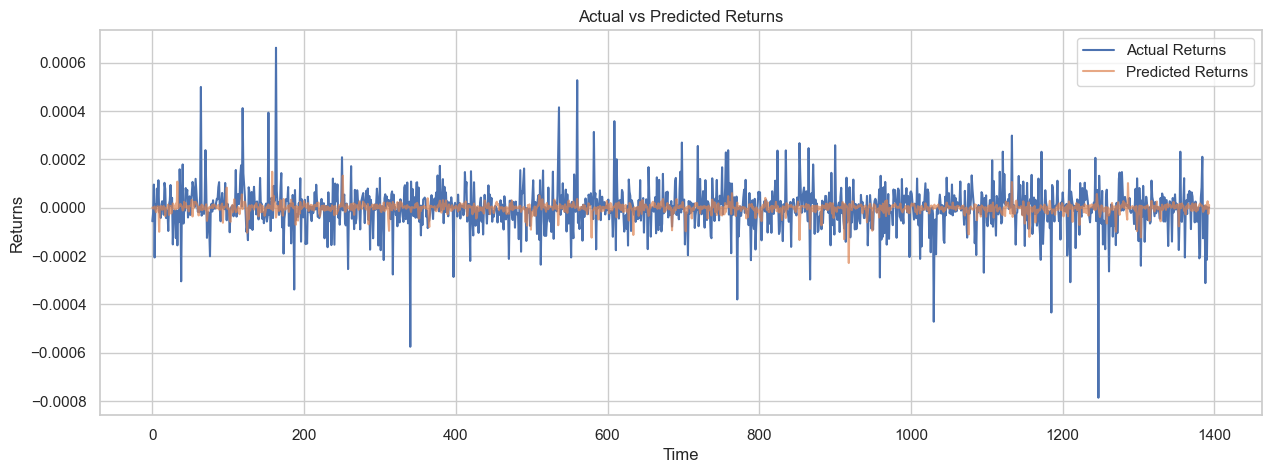

In [29]:
seq_length = 32
X, y = create_sequences(scaled_features, scaled_target, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = Sequential()
model_4.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_4.add(LSTM(100, activation='relu', return_sequences=True)) 
model_4.add(LSTM(200, activation='relu', return_sequences=False))  
model_4.add(Dense(1))

model_4.compile(optimizer='adam', loss='huber_loss')

model_4.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)

predicted_returns = model_4.predict(X_test)
predicted_returns = target_scaler.inverse_transform(predicted_returns)
actual_returns = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(actual_returns, predicted_returns)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns, predicted_returns)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

Little to no improvement 

#### Adding Dropout

Epoch 1/50
40/40 [==============================] - 11s 159ms/step - loss: 0.3302 - val_loss: 0.3724
Epoch 2/50
40/40 [==============================] - 5s 133ms/step - loss: 0.3293 - val_loss: 0.3720
Epoch 3/50
40/40 [==============================] - 5s 134ms/step - loss: 0.3291 - val_loss: 0.3726
Epoch 4/50
40/40 [==============================] - 5s 134ms/step - loss: 0.3287 - val_loss: 0.3720
Epoch 5/50
40/40 [==============================] - 5s 134ms/step - loss: 0.3290 - val_loss: 0.3723
Epoch 6/50
40/40 [==============================] - 6s 148ms/step - loss: 0.3287 - val_loss: 0.3723
Epoch 7/50
40/40 [==============================] - 7s 165ms/step - loss: 0.3283 - val_loss: 0.3721
Epoch 8/50
40/40 [==============================] - 6s 152ms/step - loss: 0.3284 - val_loss: 0.3730
Epoch 9/50
40/40 [==============================] - 6s 147ms/step - loss: 0.3280 - val_loss: 0.3730
Epoch 10/50
40/40 [==============================] - 6s 146ms/step - loss: 0.3281 - val_loss: 0.372

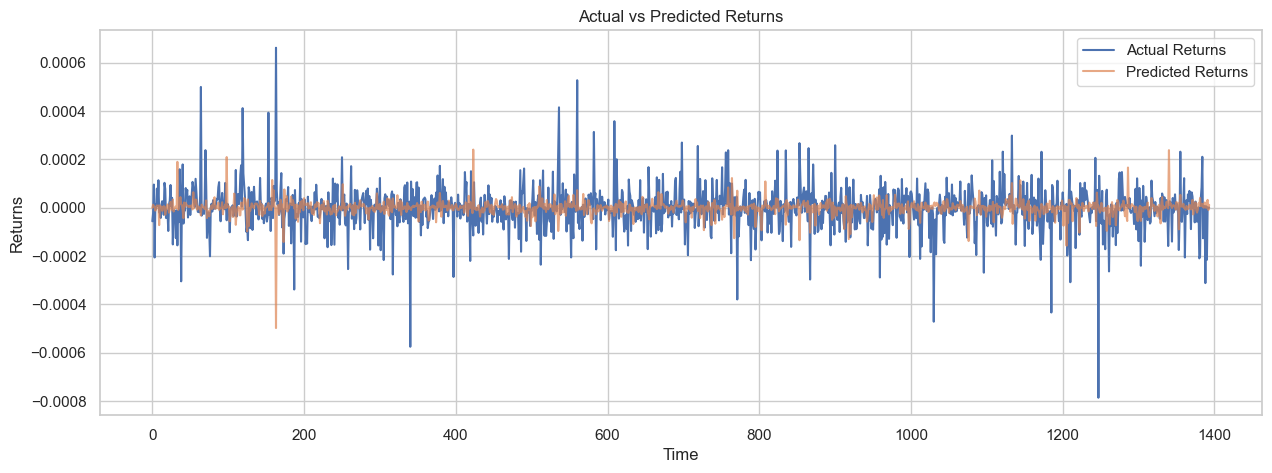

In [30]:
seq_length = 32
X, y = create_sequences(scaled_features, scaled_target, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = Sequential()
model_4.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_4.add(LSTM(100, activation='relu', return_sequences=True)) 
model_4.add(Dropout(0.2))  
model_4.add(LSTM(200, activation='relu', input_shape=(seq_length, X.shape[2]), return_sequences=False)) 
model_4.add(Dense(1))

model_4.compile(optimizer='adam', loss='huber_loss')

model_4.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)

predicted_returns = model_4.predict(X_test)
predicted_returns = target_scaler.inverse_transform(predicted_returns)
actual_returns = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(actual_returns, predicted_returns)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns, predicted_returns)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

Epoch 1/50
39/39 [==============================] - 38s 787ms/step - loss: 0.3368 - val_loss: 0.3788
Epoch 2/50
39/39 [==============================] - 29s 757ms/step - loss: 0.3301 - val_loss: 0.3802
Epoch 3/50
39/39 [==============================] - 30s 761ms/step - loss: 0.3293 - val_loss: 0.3794
Epoch 4/50
39/39 [==============================] - 29s 750ms/step - loss: 0.3293 - val_loss: 0.3800
Epoch 5/50
39/39 [==============================] - 30s 768ms/step - loss: 0.3282 - val_loss: 0.3820
Epoch 6/50
39/39 [==============================] - 30s 770ms/step - loss: 0.3279 - val_loss: 0.3794
Epoch 7/50
39/39 [==============================] - 30s 774ms/step - loss: 0.3277 - val_loss: 0.3845
Epoch 8/50
39/39 [==============================] - 30s 768ms/step - loss: 0.3274 - val_loss: 0.3803
Epoch 9/50
39/39 [==============================] - 30s 774ms/step - loss: 0.3264 - val_loss: 0.3819
Epoch 10/50
39/39 [==============================] - 30s 782ms/step - loss: 0.3261 - val_lo

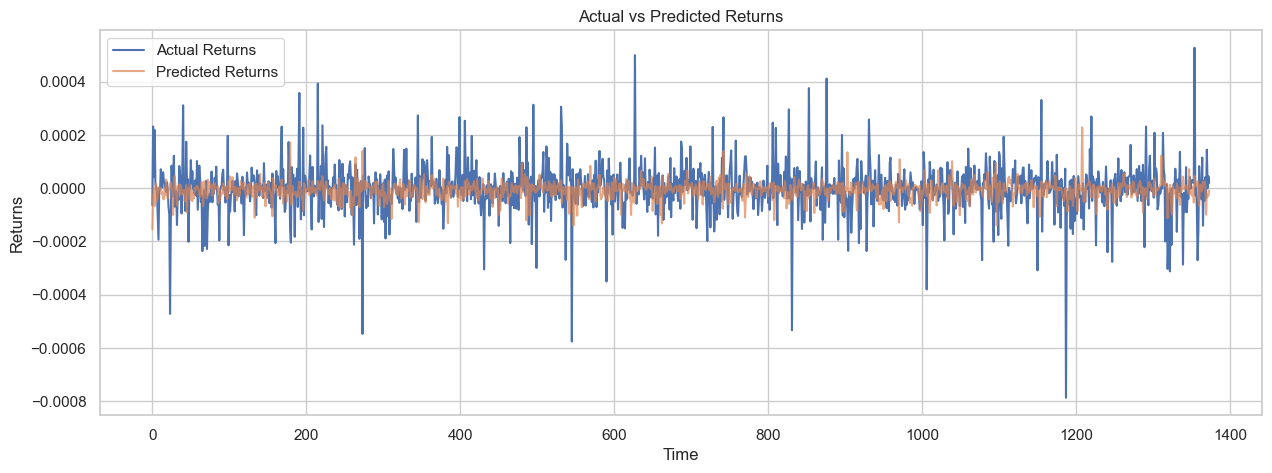

Last 100 predictions saved to last_100_predictions.csv


In [38]:
seq_length = 32
X, y = create_sequences(scaled_features, scaled_target, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = Sequential()
model_4.add(LSTM(50, activation='tanh', input_shape=(seq_length, X.shape[2]), return_sequences=True))
model_4.add(LSTM(100, activation='tanh', return_sequences=True)) 
model_4.add(Dropout(0.2))  
model_4.add(LSTM(300, activation='tanh', return_sequences=True)) 
model_4.add(Dropout(0.2))  
model_4.add(LSTM(150, activation='tanh', return_sequences=True)) 
model_4.add(LSTM(200, activation='tanh', return_sequences=False)) 
model_4.add(Dense(1))

model_4.compile(optimizer='rmsprop', loss='huber_loss')

model_4.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)

predicted_returns6 = model_4.predict(X_test)
predicted_returns6 = target_scaler.inverse_transform(predicted_returns6)
actual_returns6 = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(actual_returns6, predicted_returns6)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(actual_returns6, predicted_returns6)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns6, label='Actual Returns')
plt.plot(predicted_returns6, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

data_to_save = {
    "Actual Returns": actual_returns6[-100:].flatten(),  
    "Predicted Returns": predicted_returns6[-100:].flatten()
}
df_predictions = pd.DataFrame(data_to_save)
file_path = 'last_100_predictions.csv'
df_predictions.to_csv(file_path, index=False)

print(f"Last 100 predictions saved to {file_path}")

Epoch 1/100
158/158 [==============================] - 8s 14ms/step - loss: 1.0036 - val_loss: 0.9112
Epoch 2/100
158/158 [==============================] - 2s 10ms/step - loss: 1.0001 - val_loss: 0.9092
Epoch 3/100
158/158 [==============================] - 1s 9ms/step - loss: 1.0003 - val_loss: 0.9156
Epoch 4/100
158/158 [==============================] - 1s 9ms/step - loss: 0.9996 - val_loss: 0.9070
Epoch 5/100
158/158 [==============================] - 1s 9ms/step - loss: 0.9998 - val_loss: 0.9105
Epoch 6/100
158/158 [==============================] - 2s 10ms/step - loss: 0.9987 - val_loss: 0.9047
Epoch 7/100
158/158 [==============================] - 2s 12ms/step - loss: 0.9998 - val_loss: 0.9090
Epoch 8/100
158/158 [==============================] - 2s 12ms/step - loss: 0.9979 - val_loss: 0.9083
Epoch 9/100
158/158 [==============================] - 2s 12ms/step - loss: 0.9960 - val_loss: 0.9131
Epoch 10/100
158/158 [==============================] - 2s 12ms/step - loss: 0.9999 -

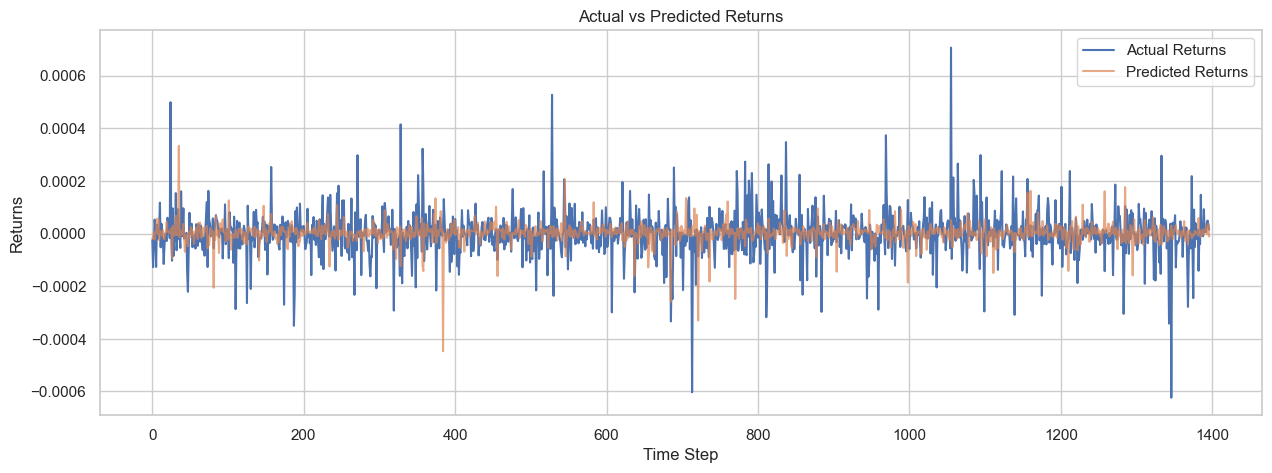

In [32]:
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(stocksData['returns'].values.reshape(-1, 1))

# Create sequences function
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
seq_length = 16
X, y = create_sequences(returns_scaled, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape features for LSTM layer
X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
X_test = X_test.reshape((X_test.shape[0], seq_length, 1))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(seq_length, 1)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predict the returns
predicted_returns = model.predict(X_test)
predicted_returns = scaler.inverse_transform(predicted_returns)  # Inverse the scaling
actual_returns = scaler.inverse_transform(y_test)  # Inverse the scaling for actual returns

# Calculate RMSE, MSE, and MAE
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
mse = mean_squared_error(actual_returns, predicted_returns)
mae = mean_absolute_error(actual_returns, predicted_returns)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.legend()
plt.show()

Epoch 1/100
157/157 [==============================] - 10s 24ms/step - loss: 0.9406 - val_loss: 1.2926
Epoch 2/100
157/157 [==============================] - 3s 18ms/step - loss: 0.9407 - val_loss: 1.2896
Epoch 3/100
157/157 [==============================] - 3s 18ms/step - loss: 0.9394 - val_loss: 1.2860
Epoch 4/100
157/157 [==============================] - 3s 21ms/step - loss: 0.9387 - val_loss: 1.2913
Epoch 5/100
157/157 [==============================] - 4s 23ms/step - loss: 0.9388 - val_loss: 1.2864
Epoch 6/100
157/157 [==============================] - 4s 23ms/step - loss: 0.9379 - val_loss: 1.2867
Epoch 7/100
157/157 [==============================] - 4s 23ms/step - loss: 0.9374 - val_loss: 1.2864
Epoch 8/100
157/157 [==============================] - 4s 22ms/step - loss: 0.9361 - val_loss: 1.2850
Epoch 9/100
157/157 [==============================] - 4s 23ms/step - loss: 0.9363 - val_loss: 1.2840
Epoch 10/100
157/157 [==============================] - 4s 22ms/step - loss: 0.93

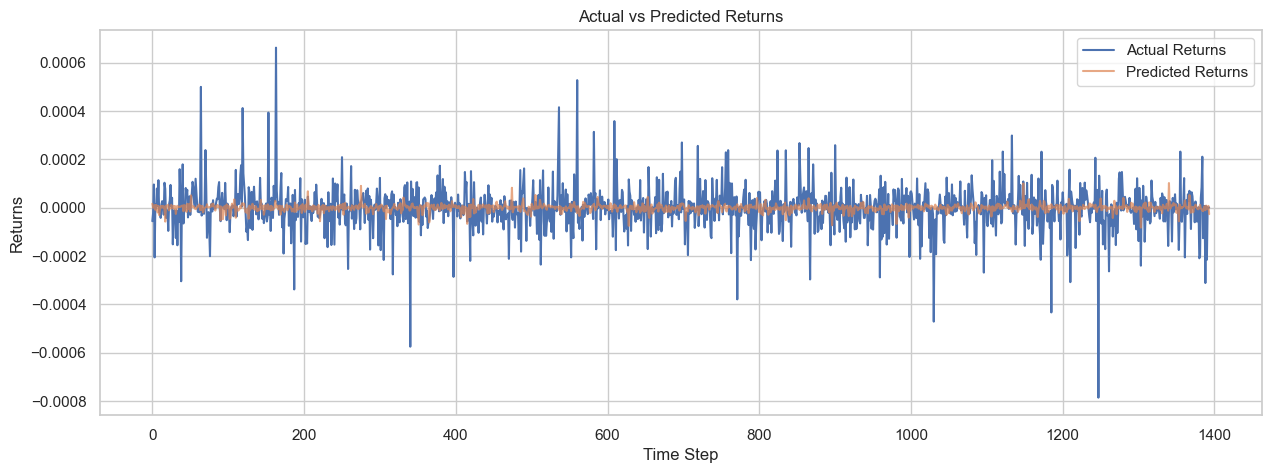

In [33]:
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(stocksData['returns'].values.reshape(-1, 1))

# Create sequences function
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
seq_length = 32
X, y = create_sequences(returns_scaled, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape features for LSTM layer
X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
X_test = X_test.reshape((X_test.shape[0], seq_length, 1))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(seq_length, 1)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Predict the returns
predicted_returns = model.predict(X_test)
predicted_returns = scaler.inverse_transform(predicted_returns)  # Inverse the scaling
actual_returns = scaler.inverse_transform(y_test)  # Inverse the scaling for actual returns

# Calculate RMSE, MSE, and MAE
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
mse = mean_squared_error(actual_returns, predicted_returns)
mae = mean_absolute_error(actual_returns, predicted_returns)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the actual vs predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.legend()
plt.show()

1/1 [==============================] - 0s 274ms/step
Iteration 100: X has an unexpected shape (0,). Skipping this iteration.


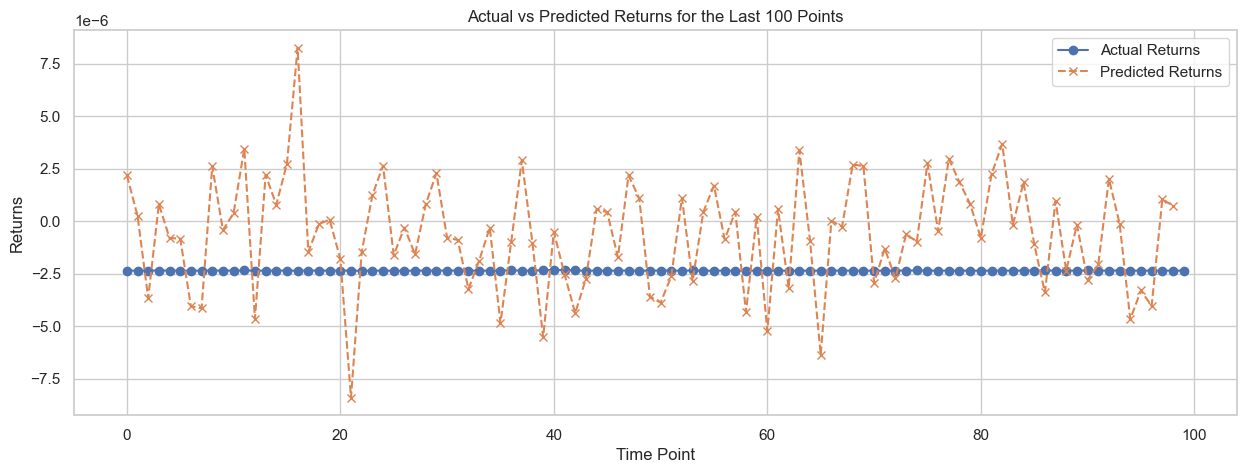

In [37]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = stocksData.drop(['returns', 'datetime'], axis=1)
returns = stocksData['returns']

# Scaling the features and returns
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_returns = target_scaler.fit_transform(returns.values.reshape(-1, 1)).flatten()

# Define a function to create sequences
def create_sequences(features, targets, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    return np.array(X), np.array(y)

# Function to create and compile the LSTM model
def create_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(100, activation='relu', return_sequences=True),
        LSTM(200, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='huber_loss')
    return model

# Prepare the data for rolling prediction
seq_length = 32
scaled_features = scaled_features[:-100]  # Use data up to the last 100 for rolling training
scaled_returns = scaled_returns[:-100]  # Adjusting targets similarly

predictions = []

for i in range(1, 101):
    try:
        # Generate sequences for the current iteration
        X, y = create_sequences(scaled_features[:-(100-i)], scaled_returns[:-(100-i)], seq_length)

        # Check if X is empty or not the expected shape, which could happen near the dataset's end
        if X.size == 0 or len(X.shape) != 3:
            print(f"Iteration {i}: X has an unexpected shape {X.shape}. Skipping this iteration.")
            continue  # Skip this iteration if the shape is not as expected
        
        # Create and compile the LSTM model
        model = create_model((seq_length, X.shape[2]))
        
        # Fit the model quietly
        model.fit(X, y, epochs=1, batch_size=128, verbose=0)
        
        # Reshape the last sequence of X for prediction and perform the prediction
        next_prediction = model.predict(X[-1].reshape(1, seq_length, X.shape[2]))
        
        # Inverse transform the prediction to its original scale and add to predictions list
        predictions.append(target_scaler.inverse_transform(next_prediction).flatten()[0])
    except Exception as e:
        print(f"Error at iteration {i}: {e}")

# Extract actual last 100 returns for comparison
actual_last_100 = target_scaler.inverse_transform(returns.values.reshape(-1, 1)[-100:]).flatten()

# Plotting actual vs. predicted returns
plt.figure(figsize=(15, 5))
plt.plot(actual_last_100, label='Actual Returns', marker='o')
plt.plot(predictions, label='Predicted Returns', marker='x', linestyle='--')
plt.title('Actual vs Predicted Returns for the Last 100 Points')
plt.xlabel('Time Point')
plt.ylabel('Returns')
plt.legend()
plt.show()
